In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import time
import datetime as dt
import json
import re, sys, os
from collections import namedtuple

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
def json_to_toplevel(f):
    tl = []
    last_tl = {}
    for l in f:
        snapshot = json.loads(l)
        for entry in snapshot['entries']:
            t = [entry['entry_name'],
                 entry['backs'][-1]['price'], entry['backs'][-1]['size'],
                 entry['lays'][0]['price'], entry['lays'][0]['size']]
            if t != last_tl.get(entry['entry_name'], []):
                tl.append([snapshot['now']] + t)
                last_tl[entry['entry_name']] = t
    tl = pd.DataFrame(tl, columns = ['time', 'name', 'back_price', 'back_size', 'lay_price', 'lay_size'])
    tl['timestamp'] = pd.to_datetime(tl.time).astype("datetime64[ns]")
    tl['back_price'] = tl['back_price'].astype('float')
    tl['lay_price']  = tl['lay_price'].astype('float')
    tl['back_size'] = tl['back_size'].str.replace('$', '').astype('int')
    tl['lay_size']  = tl['lay_size'].str.replace('$', '').astype('int')
    return tl

In [5]:
def plot_tl(tl, name, figsize=(16, 8)):
    df = tl[tl.name == name]
    fig, ax = plt.subplots(figsize=figsize)
    bid_price, ask_price = 1 / df.back_price, 1 / df.lay_price
    microprice = (bid_price * df.lay_size + ask_price * df.back_size) / (df.lay_size + df.back_size)
    ax.plot(df.timestamp, bid_price)
    ax.plot(df.timestamp, ask_price)
    ax.plot(df.timestamp, microprice)
    ax2 = ax.twinx()
    ax2.plot(df.timestamp, df.back_size, 'o-', alpha=0.3)
    ax2.plot(df.timestamp, df.lay_size, 'o-', alpha=0.3)

In [14]:
with open('2020-07-28 USA - Presidential Election 2020 - Next President.json') as f:
    pres_tl = json_to_toplevel(f)
pres_tl

,time,name,back_price,back_size,lay_price,lay_size,timestamp
0,2020-07-28T00:00:00.679Z,Joe Biden,1.61,25811,1.62,3541,2020-07-28 00:00:00.679
1,2020-07-28T00:00:00.679Z,Donald Trump,2.84,1644,2.86,10502,2020-07-28 00:00:00.679
2,2020-07-28T00:00:00.679Z,Hillary Clinton,95.00,26,100.00,131,2020-07-28 00:00:00.679
3,2020-07-28T00:00:00.679Z,Mike Pence,200.00,40,220.00,39,2020-07-28 00:00:00.679
4,2020-07-28T00:00:00.679Z,Kamala Harris,260.00,17,290.00,525,2020-07-28 00:00:00.679
...,...,...,...,...,...,...,...
3482,2020-07-28T23:52:14.181Z,Elizabeth Warren,770.00,7,990.00,8,2020-07-28 23:52:14.181
3483,2020-07-28T23:52:16.188Z,Elizabeth Warren,750.00,6,990.00,8,2020-07-28 23:52:16.188
3484,2020-07-28T23:52:35.667Z,Bernie Sanders,550.00,6,940.00,5,2020-07-28 23:52:35.667
3485,2020-07-28T23:53:51.565Z,Joe Biden,1.62,17973,1.63,41196,2020-07-28 23:53:51.565


## Market logger to CSV

Convert market-logger JSON snapshots to price depth CSV.
This parses numbers, deduplicates identical snapshots, and preserves most of the information in a more efficient format.

Raw JSONs are moved to the archive dir, ready to be dehydrated.

In [46]:
def json_to_depth(f, empty_nan=True, levels=3):
    '''
    Convert raw JSON to price depth ticks per candidate, removing duplicate ticks.
     * f: iterable of market-logger lines, each containing a raw JSON snapshot
     * empty_nan: convert 0s in raw JSON (empty level) to NaN. You normally want this.
     * levels: number of levels to keep. BetFair web UI default is 3.

    Returns dataframe columns:
     * time - text timestamp
     * timestamp - datetime64
     * name - candidate name
     * for i in range(levels):
       * back_price_i, back_size_i, lay_price_i, lay_size_i
       * price = odds (float)
       * size = wager (int in $)
       * i=0 is best back/lay
     * total_matched - int in $
    '''
    depth = []
    last_depth = {}
    for l in f:
        snapshot = json.loads(l)
        total_matched = int(re.sub('[^0-9.]', '', snapshot['total_matched']))
        for entry in snapshot['entries']:
            t = [entry['entry_name']]

            backs = entry['backs']
            if len(backs) != levels: # unlikely
                backs = ([('0', '0')] * levels + backs)[-levels:]
            for back in backs:
                t.append(float(back['price']))
                t.append(int(back['size'].replace('$', '')))

            lays = entry['lays']
            if len(lays) != levels: # unlikely
                lays = (lays + [('0', '0')] * levels)[:levels]
            for lay in lays:
                t.append(float(lay['price']))
                t.append(int(lay['size'].replace('$', '')))

            # remove dups
            if t != last_depth.get(entry['entry_name'], []):
                depth.append([snapshot['now']] + t + [total_matched])
                last_depth[entry['entry_name']] = t

    columns = ['time', 'name']
    for i in range(levels-1, -1, -1):
        columns += [f'back_price_{i}', f'back_size_{i}']
    for i in range(levels):
        columns += [f'lay_price_{i}', f'lay_size_{i}']
    columns += ['total_matched']

    depth = pd.DataFrame(depth, columns = columns)

    if empty_nan:
        for i in range(levels):
            for side in 'lay', 'back':
                depth.loc[depth[f'{side}_price_{i}'] == 0, [f'{side}_price_{i}', f'{side}_size_{i}']] = np.nan
    depth['timestamp'] = pd.to_datetime(depth.time).astype("datetime64[ns]")
    return depth

In [447]:
dates_to_archive = [
    '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31',
]
archive_path = './log-archive'
for f in sorted(os.listdir('.')):
    if any(f.startswith(d) for d in dates_to_archive) and f.endswith('.json'):
        try:
            with open(f, 'r') as raw_data:
                depth = json_to_depth(raw_data)
        except Exception as e:
            print(f"*** Failed to read market log: {f}: {e}")
            continue
        try:
            f_out = re.sub(r'\.json', '.csv', f)
            if os.path.exists(f_out):
                print(f"*** Can't process as destination already exists: {f_out}")
                continue
            depth.to_csv(f_out, header=True, index=False)
            os.rename(f, os.path.join(archive_path, f))
        except Exception as e:
            print(f"*** Failed to archive market log: {f}: {e}")
            try:
                os.unlink(f_out)
            except:
                pass
            continue
        print(f"Processed: {f}")

Processed: 2020-07-30 USA - Presidential Election 2020 - Biden Electoral College Votes.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Biden Vote Percentage.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Democratic Nominee.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Democratic Vice Presidential Candidate.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Next President.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Nominee Forecast.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Popular Vote Winner.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Republican Nominee.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Republican Vice Presidential Candidate.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Trump Electoral College Votes.json
Processed: 2020-07-30 USA - Presidential Election 2020 - Trump Vote Percentage.json
Processed: 2020-07-30 USA - Presidential Elect

# Order inference

Guessing trades from book changes and the "total matched" counter.

In [213]:
def is_behind(side, p1, p2):
    return (np.isnan(p1) and not np.isnan(p2)) or (p1 < p2 if side == 'back' else p1 > p2)
def is_in_front_of(side, p1, p2):
    return is_behind(side, p2, p1)

assert is_behind('back', 1, 2)
assert is_behind('lay',  2, 1)
assert not is_behind('back', 1, 1)
assert is_behind('back', np.nan, 1)
assert not is_behind('back', np.nan, np.nan)

def guess_traded(depth):
    '''
    Infer trades from changes in depth.
    Returned columns:
    * trade_side:      'back' or 'lay', NaN if no trade inferred
    * trade_price:     price that would match the whole size in one bet
    * trade_size:      size matched
    * trade_remaining: remaining size on the other side.
        If > 0, more likely that this is a real trade; 0 could just be a retreat
    '''
    PriceSize = namedtuple('PriceSize', ('price', 'size'))

    back_cols = sorted(col for col in depth.columns if 'back_' in col)
    back_cols = list(zip([col for col in back_cols if 'price' in col], [col for col in back_cols if 'size' in col]))
    back_cols = [PriceSize(*cols) for cols in back_cols]
    lay_cols = sorted(col for col in depth.columns if 'lay_' in col)
    lay_cols = list(zip([col for col in lay_cols if 'price' in col], [col for col in lay_cols if 'size' in col]))
    lay_cols = [PriceSize(*cols) for cols in lay_cols]
    def guess_per_name(df):
        def guess_side(now, prev, side, other_side, side_cols, other_side_cols):
            this_side_price = df.loc[now, side_cols[0].price]
            this_side_size = df.loc[now, side_cols[0].size]

            top_price, prev_top_price = (df.loc[i, other_side_cols[0].price] for i in (now, prev))
            if is_in_front_of(other_side, top_price, prev_top_price):
                return None
            top_size, prev_top_size = (df.loc[i, other_side_cols[0].size] for i in (now, prev))
            if np.isnan(prev_top_price) or (top_price == prev_top_price and top_size >= prev_top_size):
                return None

            size = 0 # traded size
            remaining_size = 0
            price = np.nan
            #print((side, (top_price, top_size), df.loc[prev]))
            for ps in other_side_cols:
                #print((df.loc[prev, ps.price], df.loc[prev, ps.size]))
                if is_behind(other_side, df.loc[prev, ps.price], top_price):
                    # Behind the current top price, no more matches
                    break
                if df.loc[prev, ps.price] == top_price:
                    # Reached current top price, possibly taking some size from it
                    if df.loc[prev, ps.size] > top_size:
                        price = df.loc[prev, ps.price]
                        size += df.loc[prev, ps.size] - top_size
                    # Check if there's remaining size
                    if this_side_price == price:
                        remaining_size = this_side_size
                    break
                # Still in front. First check if we flipped the book to our side
                if not is_behind(side, this_side_price, prev_top_price):
                     # If this flipped top crosses the prev other side, guess a trade at this price
                    if is_behind(other_side, df.loc[prev, ps.price], this_side_price):
                        price = this_side_price
                        remaining_size = this_side_size
                        break
                size += df.loc[prev, ps.size]
                price = df.loc[prev, ps.price]
            if not np.isnan(price) and size > 0:
                return (side, price, size, remaining_size)
            return None

        prev_idx = None
        trades = []
        for idx in df.index:
            if prev_idx is not None:
                trades.append(guess_side(idx, prev_idx, 'back', 'lay', back_cols, lay_cols)
                              or guess_side(idx, prev_idx, 'lay', 'back', lay_cols, back_cols)
                              or (np.nan,) * 4)
            else:
                trades.append((np.nan,) * 4)
            prev_idx = idx
        trades = pd.DataFrame(trades, columns=['trade_side', 'trade_price', 'trade_size', 'trade_remaining'])
        trades.index = df.index
        return trades

    return depth.groupby('name').apply(guess_per_name)

def infer_traded(depth, time_threshold = pd.Timedelta(2, unit='s'), abs_threshold = 5, rel_threshold = 0.05):
    '''
    Like guess_traded, but discards trades that don't align with
    total_matched changes (these tend to not be real trades).

    Returns a dataframe of depth + inferred trades.
    
    time_threshold: Timedelta for finding a total_matched delta
      - Note: we enforce 1-to-1 size matching, but we don't try for an optimal matching currently.

    abs_threshold, rel_threshold:
      Absolute (dollars) and relative (fraction) size tolerance.
      Size traded must match within one of these thresholds to be considered a real trade.
    '''
    
    depth = depth.copy()
    depth['matched'] = depth.total_matched.diff()
    depth = pd.concat((depth, guess_traded(depth)), axis=1)
    match_i = 0
    for i in depth.index:
        while match_i < len(depth) and depth.timestamp[depth.index[match_i]] < depth.timestamp[i] - time_threshold:
            match_i += 1
        if depth.trade_size[i] > 0:
            j = match_i
            found_match = False
            for j in range(match_i, len(depth)):
                if depth.timestamp[depth.index[j]] > depth.timestamp[i] + time_threshold:
                    break
                # Betfair includes both sides of the trade in matched size, so divide by 2
                matched = depth.matched[depth.index[j]] / 2
                if (matched > 0
                    and (abs(matched - depth.trade_size[i]) < abs_threshold
                         or abs(matched / depth.trade_size[i] - 1) < rel_threshold)):
                    match_i = j + 1 # don't use this matched volume again
                    found_match = True
                    break
            if not found_match:
                depth.loc[i, ['trade_side', 'trade_size', 'trade_price', 'trade_remaining']] = np.nan
    return depth

In [405]:
vp = None
for d in [27, 28, 29, 30]:
    df = pd.read_csv(f'2020-07-{d} USA - Presidential Election 2020 - Democratic Vice Presidential Candidate.csv')
    vp = df if vp is None else pd.concat((vp, df))
vp.timestamp = pd.to_datetime(vp.timestamp).astype("datetime64[ns]")
vp = vp.reset_index(drop=True)
vp

,time,name,back_price_2,back_size_2,back_price_1,back_size_1,back_price_0,back_size_0,lay_price_0,lay_size_0,lay_price_1,lay_size_1,lay_price_2,lay_size_2,total_matched,timestamp
0,2020-07-27T00:00:00.184Z,Kamala Harris,2.48,9.0,2.50,180.0,2.52,72.0,2.60,67.0,2.62,50.0,2.64,74.0,2639268,2020-07-27 00:00:00.184
1,2020-07-27T00:00:00.184Z,Susan Rice,4.60,360.0,4.80,22.0,4.90,18.0,5.10,89.0,5.20,109.0,5.30,55.0,2639268,2020-07-27 00:00:00.184
2,2020-07-27T00:00:00.184Z,Karen Bass,7.80,5.0,8.00,12.0,8.20,13.0,9.00,21.0,9.20,29.0,9.40,18.0,2639268,2020-07-27 00:00:00.184
3,2020-07-27T00:00:00.184Z,Tammy Duckworth,9.00,10.0,9.40,7.0,10.50,8.0,13.50,20.0,14.00,16.0,16.50,492.0,2639268,2020-07-27 00:00:00.184
4,2020-07-27T00:00:00.184Z,Elizabeth Warren,15.50,91.0,16.00,212.0,16.50,11.0,17.50,85.0,18.00,20.0,18.50,360.0,2639268,2020-07-27 00:00:00.184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32020,2020-07-30T22:19:48.481Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,976.0,1.82,22.0,1.83,229.0,1.84,174.0,3321871,2020-07-30 22:19:48.481
32021,2020-07-30T22:19:49.479Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,976.0,1.82,89.0,1.83,229.0,1.84,174.0,3321871,2020-07-30 22:19:49.479
32022,2020-07-30T22:20:02.492Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,21.0,1.82,89.0,1.83,229.0,1.84,174.0,3323780,2020-07-30 22:20:02.492
32023,2020-07-30T22:23:56.383Z,Susan Rice,5.50,20.0,5.60,23.0,5.70,54.0,6.00,71.0,6.20,30.0,6.40,204.0,3323877,2020-07-30 22:23:56.383


In [406]:
vp_trades = infer_traded(vp)
vp_trades

,time,name,back_price_2,back_size_2,back_price_1,back_size_1,back_price_0,back_size_0,lay_price_0,lay_size_0,...,lay_size_1,lay_price_2,lay_size_2,total_matched,timestamp,matched,trade_side,trade_price,trade_size,trade_remaining
0,2020-07-27T00:00:00.184Z,Kamala Harris,2.48,9.0,2.50,180.0,2.52,72.0,2.60,67.0,...,50.0,2.64,74.0,2639268,2020-07-27 00:00:00.184,NaN,NaN,NaN,NaN,NaN
1,2020-07-27T00:00:00.184Z,Susan Rice,4.60,360.0,4.80,22.0,4.90,18.0,5.10,89.0,...,109.0,5.30,55.0,2639268,2020-07-27 00:00:00.184,0.0,NaN,NaN,NaN,NaN
2,2020-07-27T00:00:00.184Z,Karen Bass,7.80,5.0,8.00,12.0,8.20,13.0,9.00,21.0,...,29.0,9.40,18.0,2639268,2020-07-27 00:00:00.184,0.0,NaN,NaN,NaN,NaN
3,2020-07-27T00:00:00.184Z,Tammy Duckworth,9.00,10.0,9.40,7.0,10.50,8.0,13.50,20.0,...,16.0,16.50,492.0,2639268,2020-07-27 00:00:00.184,0.0,NaN,NaN,NaN,NaN
4,2020-07-27T00:00:00.184Z,Elizabeth Warren,15.50,91.0,16.00,212.0,16.50,11.0,17.50,85.0,...,20.0,18.50,360.0,2639268,2020-07-27 00:00:00.184,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32020,2020-07-30T22:19:48.481Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,976.0,1.82,22.0,...,229.0,1.84,174.0,3321871,2020-07-30 22:19:48.481,561.0,lay,1.81,282.0,0.0
32021,2020-07-30T22:19:49.479Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,976.0,1.82,89.0,...,229.0,1.84,174.0,3321871,2020-07-30 22:19:49.479,0.0,NaN,NaN,NaN,NaN
32022,2020-07-30T22:20:02.492Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,21.0,1.82,89.0,...,229.0,1.84,174.0,3323780,2020-07-30 22:20:02.492,1909.0,lay,1.80,955.0,0.0
32023,2020-07-30T22:23:56.383Z,Susan Rice,5.50,20.0,5.60,23.0,5.70,54.0,6.00,71.0,...,30.0,6.40,204.0,3323877,2020-07-30 22:23:56.383,97.0,NaN,NaN,NaN,NaN


In [407]:
# All inferred trades
vp_trades[~vp_trades.trade_side.isna()]

,time,name,back_price_2,back_size_2,back_price_1,back_size_1,back_price_0,back_size_0,lay_price_0,lay_size_0,...,lay_size_1,lay_price_2,lay_size_2,total_matched,timestamp,matched,trade_side,trade_price,trade_size,trade_remaining
48,2020-07-27T00:08:23.455Z,Valerie Jarrett,300.00,20.0,390.00,6.0,400.00,39.0,NaN,NaN,...,NaN,NaN,NaN,2639270,2020-07-27 00:08:23.455,2.0,lay,400.00,2.0,0.0
51,2020-07-27T00:18:43.364Z,Oprah Winfrey,360.00,32.0,400.00,32.0,510.00,7.0,1000.00,91.0,...,NaN,NaN,NaN,2639279,2020-07-27 00:18:43.364,9.0,back,1000.00,5.0,0.0
52,2020-07-27T00:19:00.427Z,Nadja West,360.00,33.0,390.00,6.0,400.00,9.0,800.00,7.0,...,NaN,NaN,NaN,2639297,2020-07-27 00:19:00.427,18.0,back,800.00,8.0,0.0
53,2020-07-27T00:19:43.342Z,Gretchen Whitmer,44.00,5.0,55.00,7.0,60.00,31.0,75.00,18.0,...,40.0,95.00,108.0,2639317,2020-07-27 00:19:43.342,20.0,lay,60.00,10.0,0.0
54,2020-07-27T00:19:56.374Z,Tammy Duckworth,8.80,7.0,9.00,14.0,10.00,13.0,13.50,21.0,...,16.0,16.50,492.0,2639333,2020-07-27 00:19:56.374,16.0,lay,10.50,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32011,2020-07-30T22:12:38.423Z,Kamala Harris,1.80,954.0,1.81,265.0,1.82,40.0,1.83,469.0,...,120.0,1.85,396.0,3320750,2020-07-30 22:12:38.423,364.0,back,1.83,182.0,0.0
32013,2020-07-30T22:14:10.683Z,Kamala Harris,1.80,954.0,1.81,265.0,1.82,40.0,1.83,229.0,...,145.0,1.85,396.0,3321230,2020-07-30 22:14:10.683,480.0,back,1.83,240.0,0.0
32018,2020-07-30T22:19:32.675Z,Kamala Harris,1.79,191.0,1.80,974.0,1.81,282.0,1.83,229.0,...,174.0,1.85,421.0,3321310,2020-07-30 22:19:32.675,80.0,lay,1.82,40.0,0.0
32020,2020-07-30T22:19:48.481Z,Kamala Harris,1.78,256.0,1.79,191.0,1.80,976.0,1.82,22.0,...,229.0,1.84,174.0,3321871,2020-07-30 22:19:48.481,561.0,lay,1.81,282.0,0.0


In [378]:
betfair_ticks = pd.Series(
    [  1 + 0.01 * t for t in range(100)] +
    [  2 + 0.02 * t for t in range(50)] +
    [  3 + 0.05 * t for t in range(20)] +
    [  4 + 0.1  * t for t in range(20)] +
    [  6 + 0.2  * t for t in range(20)] +
    [ 10 + 0.5  * t for t in range(20)] +
    [ 20 + 1    * t for t in range(10)] +
    [ 30 + 2    * t for t in range(10)] +
    [ 50 + 5    * t for t in range(10)] +
    [100 + 10   * t for t in range(91)])

betfair_major_ticks = pd.Series(
    [  1 + 0.1 * t for t in range(10)] +
    [  2 + 0.2 * t for t in range(5)] +
    [  3 + 0.5 * t for t in range(2)] +
    [  4 + 1   * t for t in range(2)] +
    [  6 + 2   * t for t in range(2)] +
    [ 10 + 5   * t for t in range(2)] +
    [ 20 + 5   * t for t in range(2)] +
    [ 30 + 10  * t for t in range(2)] +
    [ 50 + 10  * t for t in range(5)] +
    [100 + 100 * t for t in range(10)])

import matplotlib.ticker
def set_bf_ticks(ax, prices):
    '''
    Decorate Betfair odds on y-axis.
    This shows prices (odds) on left y-axis and implied probability on right y-axis.

    Note: data should be plotted with probabilities, not odds.
    '''
    ax2 = ax.twinx()
    ax.set_ylabel('Odds')
    ax2.set_ylabel('Prob')
    major_ticks = betfair_major_ticks[(betfair_major_ticks.shift(0) >= prices.min()) & (betfair_major_ticks.shift(0) <= prices.max())]
    minor_ticks = betfair_ticks[(betfair_ticks.shift(-1) >= prices.min()) & (betfair_ticks.shift(1) <= prices.max()) & ~betfair_ticks.isin(major_ticks)]
    ax.set_yticks(1 / major_ticks, minor=False)
    ax.set_yticks(1 / minor_ticks, minor=True)
    ax2.set_ylim(ax.get_ylim())
    ax.yaxis.grid(which="major", color='grey', linestyle='-', alpha=1)
    ax.yaxis.grid(which="minor", color='grey', linestyle='--', alpha=0.2)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: '%.3g' % (1/x)))
    ax.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(lambda x,pos: '%.3g' % (1/x)))

In [370]:
def ewap(df, price_cols, size_cols, base=0.5):
    '''
    Exponential weighted average price of several price levels.
    price_cols and size_cols should be lists of column names in the given df.

    The i-th level is weighted by size * base^i. base defaults to 1/2.
    '''
    size_weight = pd.DataFrame([[base**i for i in range(len(price_cols))]], columns=price_cols).iloc[0]
    sizes = df[size_cols].rename(columns=dict(zip(size_cols, price_cols)))
    return ((df[price_cols] * sizes * size_weight).sum(axis=1, skipna=True)
            / (sizes * size_weight).sum(axis=1, skipna=True))

In [379]:
def plot_depth_trades(depth_trades, name, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    df = depth_trades[vp_trades.name == name]

    ax.plot(df.timestamp, 1 / df.back_price_0, '--', color='b', alpha=0.5, label='Top back price')
    ax.plot(df.timestamp, 1 / df.lay_price_0, '--', color='r', alpha=0.5, label='Top lay price')

    back_ewap = ewap(df, [f'back_price_{i}' for i in range(3)], [f'back_size_{i}' for i in range(3)])
    lay_ewap  = ewap(df, [f'lay_price_{i}' for i in range(3)], [f'lay_size_{i}' for i in range(3)])
    ax.plot(df.timestamp, 1 / back_ewap, '-', color='b', alpha=0.5, label='Back EWAP')
    ax.plot(df.timestamp, 1 / lay_ewap, '-', color='r', alpha=0.5, label='Lay EWAP')

    microprice = (1 / df.back_price_0 * df.lay_size_0 + 1 / df.lay_price_0 * df.back_size_0) / (df.back_size_0 + df.lay_size_0)
    ax.plot(df.timestamp, microprice, '--', color='#ff00ff', label='Microprice')

    ax.scatter(df.timestamp, 1 / df.trade_price, s=10*np.log(df.trade_size+1), color=df.trade_side.apply(lambda x: 'g' if x == 'back' else 'r'),
               alpha=1, label='Trade')
    ax.legend()
    ax.set_xlabel('UTC')
    ax.set_title(name)

    set_bf_ticks(ax, pd.concat((df.back_price_1, df.lay_price_1)))

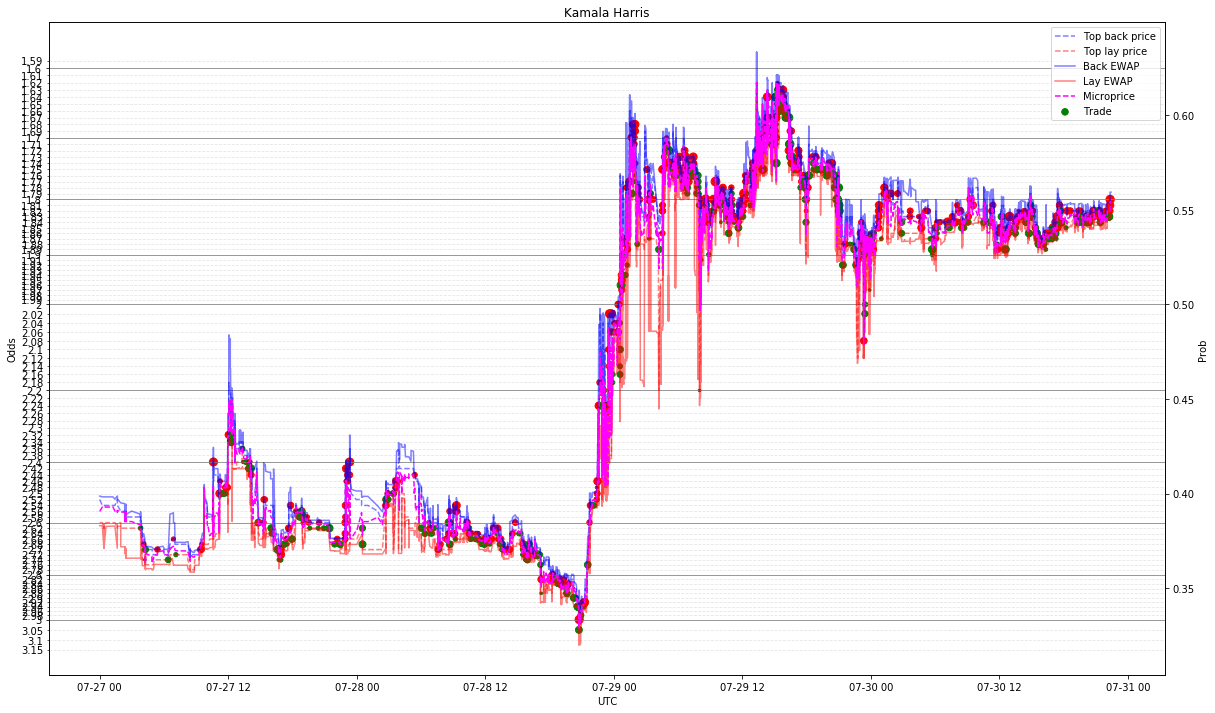

In [408]:
plot_depth_trades(vp_trades, 'Kamala Harris', figsize=(20, 12))

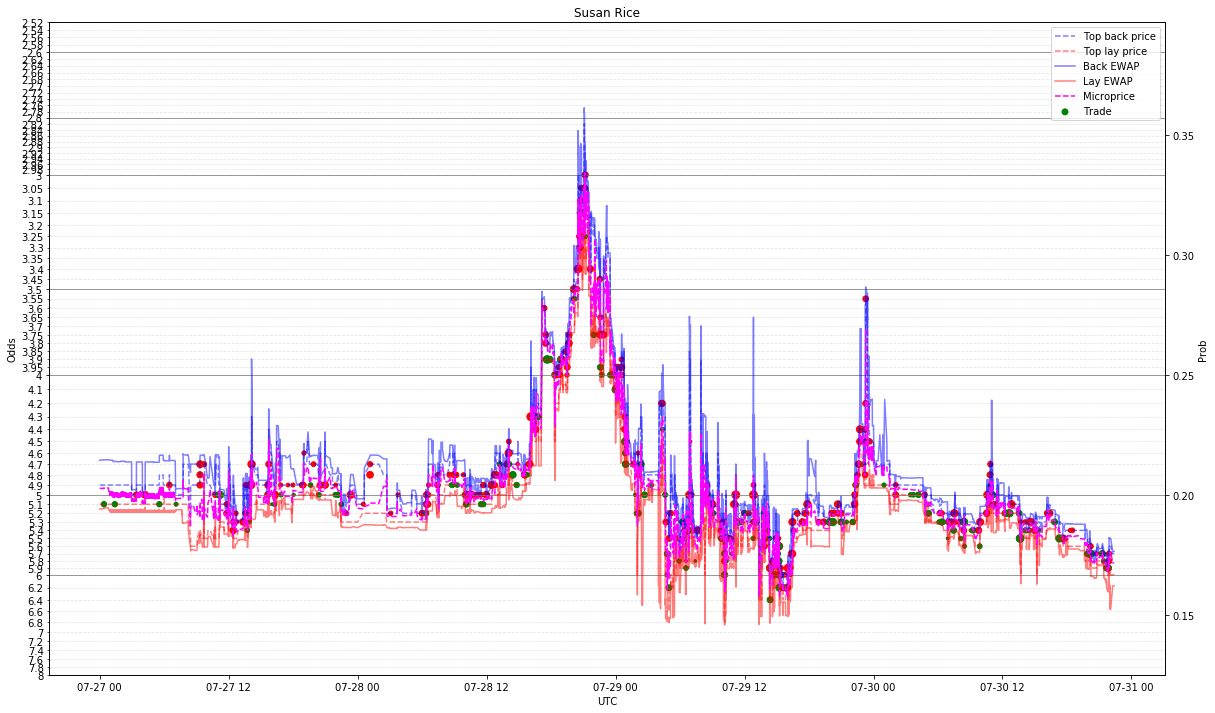

In [409]:
plot_depth_trades(vp_trades, 'Susan Rice', figsize=(20, 12))

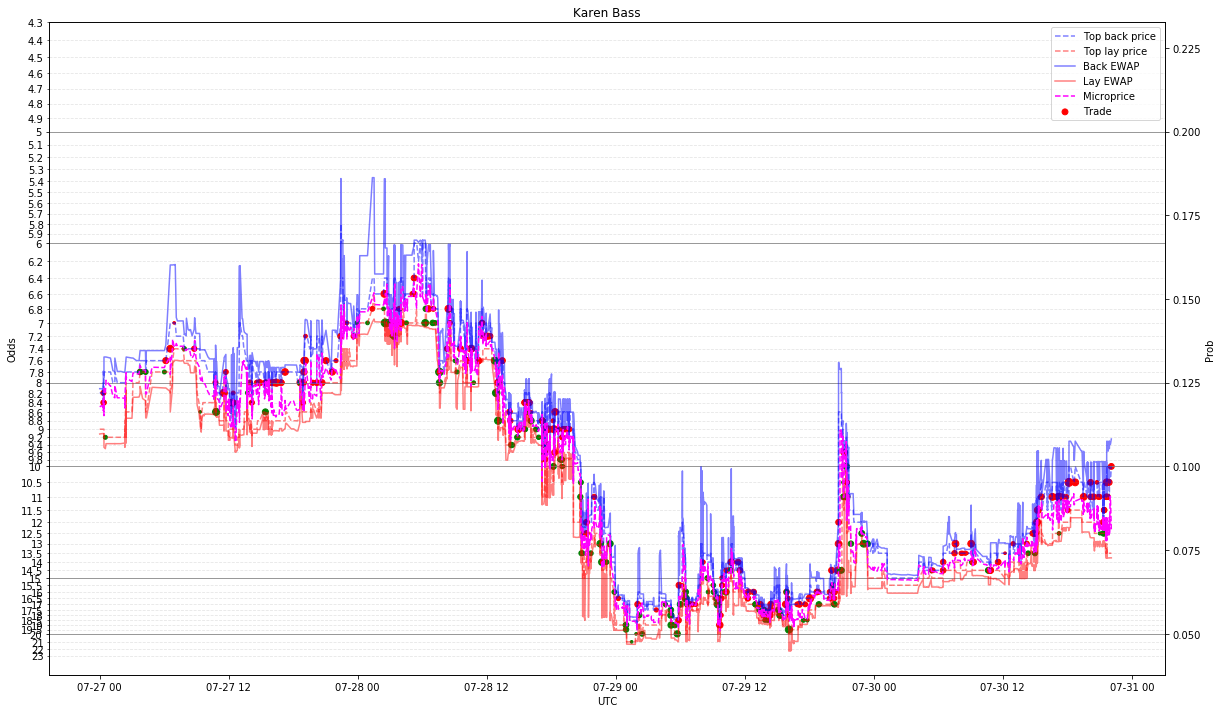

In [410]:
plot_depth_trades(vp_trades, 'Karen Bass', figsize=(20, 12))

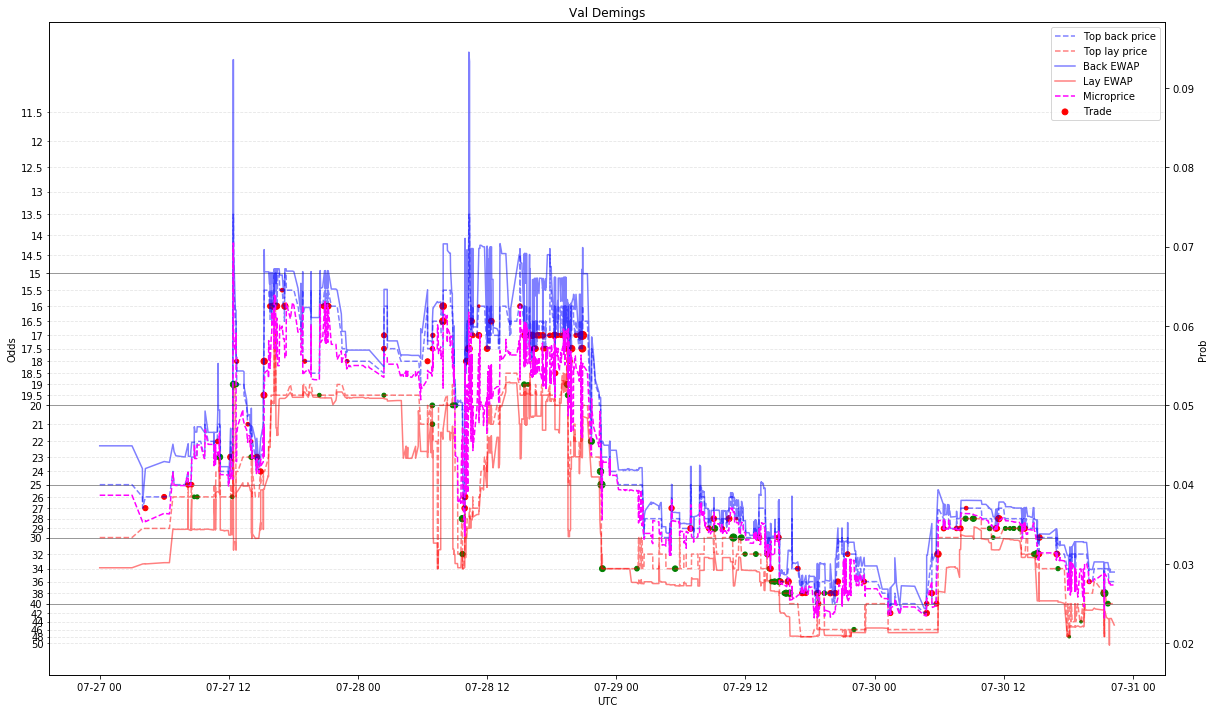

In [411]:
plot_depth_trades(vp_trades, 'Val Demings', figsize=(20, 12))

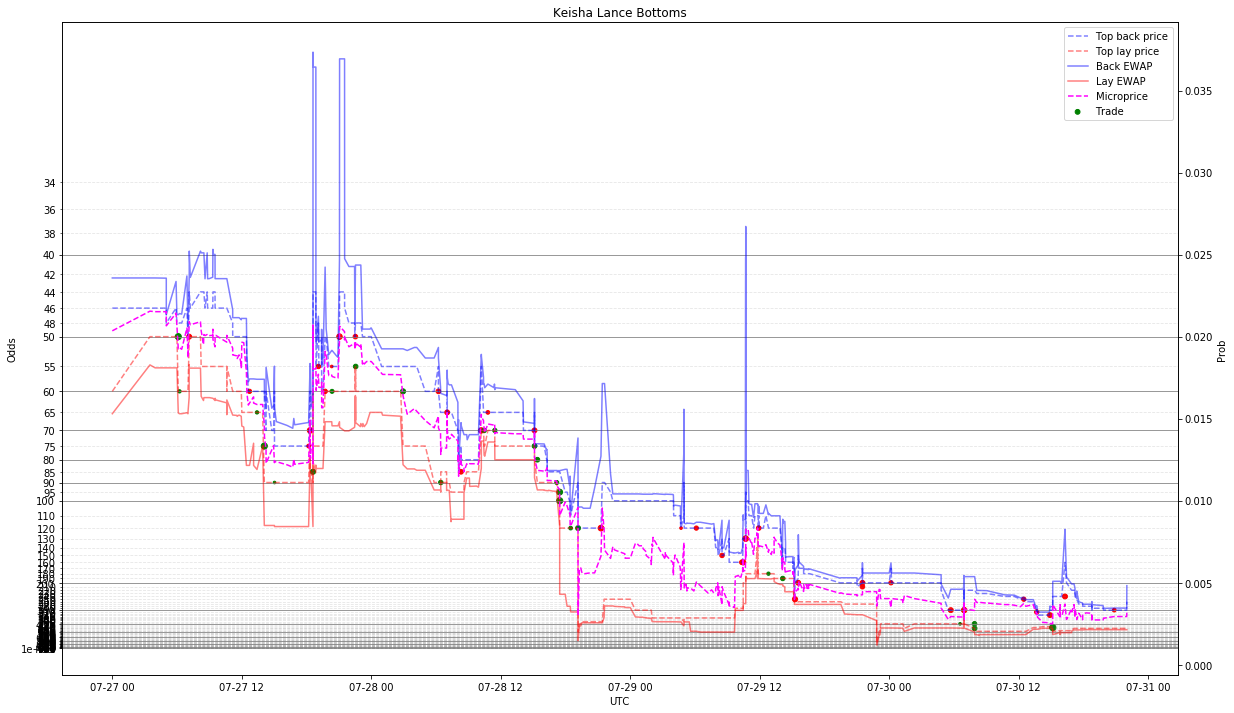

In [413]:
plot_depth_trades(vp_trades, 'Keisha Lance Bottoms', figsize=(20, 12))

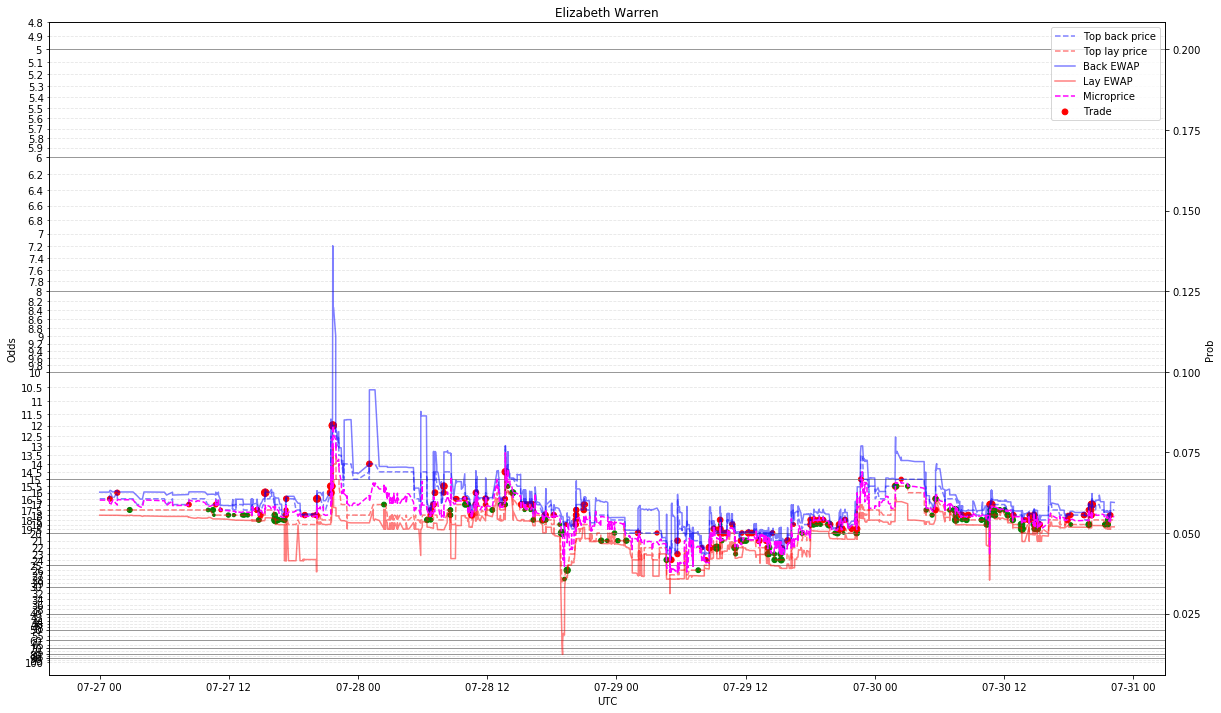

In [412]:
plot_depth_trades(vp_trades, 'Elizabeth Warren', figsize=(20, 12))

In [209]:
print((vp_trades.total_matched.max() - vp_trades.total_matched.min()) / 2)
vp_trades.trade_size.cumsum().fillna(method='ffill')

80077.0


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
5911    36313.0
5912    36313.0
5913    37268.0
5914    37268.0
5915    37268.0
Name: trade_size, Length: 5916, dtype: float64

# Distribution markets

In [ ]:
def plot_depth_stacked(depth_trades, name, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    df = depth_trades[vp_trades.name == name]

    ax.plot(df.timestamp, 1 / df.back_price_0, '--', color='b', alpha=0.5, label='Top back price')
    ax.plot(df.timestamp, 1 / df.lay_price_0, '--', color='r', alpha=0.5, label='Top lay price')

    back_ewap = ewap(df, [f'back_price_{i}' for i in range(3)], [f'back_size_{i}' for i in range(3)])
    lay_ewap  = ewap(df, [f'lay_price_{i}' for i in range(3)], [f'lay_size_{i}' for i in range(3)])
    ax.plot(df.timestamp, 1 / back_ewap, '-', color='b', alpha=0.5, label='Back EWAP')
    ax.plot(df.timestamp, 1 / lay_ewap, '-', color='r', alpha=0.5, label='Lay EWAP')

    microprice = (1 / df.back_price_0 * df.lay_size_0 + 1 / df.lay_price_0 * df.back_size_0) / (df.back_size_0 + df.lay_size_0)
    ax.plot(df.timestamp, microprice, '--', color='#ff00ff', label='Microprice')

    ax.scatter(df.timestamp, 1 / df.trade_price, s=10*np.log(df.trade_size+1), color=df.trade_side.apply(lambda x: 'g' if x == 'back' else 'r'),
               alpha=1, label='Trade')
    ax.legend()
    ax.set_xlabel('UTC')
    ax.set_title(name)

    set_bf_ticks(ax, pd.concat((df.back_price_1, df.lay_price_1)))

In [441]:
b_vote = None
for d in [27, 28, 29, 30]:
    df = pd.read_csv(f'2020-07-{d} USA - Presidential Election 2020 - Biden Vote Percentage.csv')
    b_vote = df if b_vote is None else pd.concat((b_vote, df))
b_vote.timestamp = pd.to_datetime(b_vote.timestamp).astype("datetime64[ns]")
b_vote = b_vote.reset_index(drop=True)
b_vote = infer_traded(b_vote)
b_vote

,time,name,back_price_2,back_size_2,back_price_1,back_size_1,back_price_0,back_size_0,lay_price_0,lay_size_0,...,lay_size_1,lay_price_2,lay_size_2,total_matched,timestamp,matched,trade_side,trade_price,trade_size,trade_remaining
0,2020-07-27T00:00:00.354Z,39.99 Percent or less,30.00,36.0,32.0,32.0,40.00,6.0,55.0,28.0,...,6.0,200.0,14.0,4066,2020-07-27 00:00:00.354,NaN,NaN,NaN,NaN,NaN
1,2020-07-27T00:00:00.354Z,40.00 - 42.99 Percent,15.00,5.0,20.0,54.0,23.00,8.0,55.0,50.0,...,10.0,NaN,NaN,4066,2020-07-27 00:00:00.354,0.0,NaN,NaN,NaN,NaN
2,2020-07-27T00:00:00.354Z,43.00 - 45.99 Percent,15.00,17.0,15.5,6.0,20.00,7.0,25.0,93.0,...,6.0,40.0,8.0,4066,2020-07-27 00:00:00.354,0.0,NaN,NaN,NaN,NaN
3,2020-07-27T00:00:00.354Z,46.00 - 48.99 Percent,5.90,25.0,6.2,6.0,7.20,45.0,18.0,36.0,...,NaN,NaN,NaN,4066,2020-07-27 00:00:00.354,0.0,NaN,NaN,NaN,NaN
4,2020-07-27T00:00:00.354Z,49.00 - 51.99 Percent,3.65,153.0,3.7,13.0,3.75,21.0,4.0,13.0,...,120.0,5.0,492.0,4066,2020-07-27 00:00:00.354,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,2020-07-30T19:33:55.190Z,46.00 - 48.99 Percent,6.00,30.0,6.2,42.0,6.80,5.0,8.4,6.0,...,6.0,17.5,5.0,4354,2020-07-30 19:33:55.190,1.0,NaN,NaN,NaN,NaN
381,2020-07-30T20:00:36.181Z,46.00 - 48.99 Percent,6.00,30.0,6.2,41.0,6.80,5.0,8.4,6.0,...,6.0,17.5,5.0,4350,2020-07-30 20:00:36.181,-4.0,NaN,NaN,NaN,NaN
382,2020-07-30T20:00:36.181Z,49.00 - 51.99 Percent,4.00,12.0,4.3,51.0,4.40,20.0,4.7,5.0,...,121.0,5.0,494.0,4350,2020-07-30 20:00:36.181,0.0,NaN,NaN,NaN,NaN
383,2020-07-30T22:00:32.182Z,46.00 - 48.99 Percent,6.00,30.0,6.2,41.0,6.80,5.0,8.4,5.0,...,6.0,17.5,5.0,4346,2020-07-30 22:00:32.182,-4.0,NaN,NaN,NaN,NaN


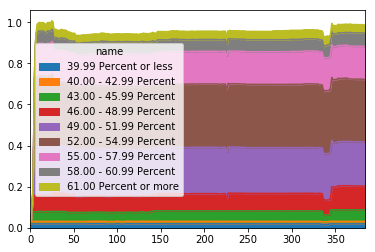

In [442]:
df = b_vote.copy()
for side in ('back', 'lay'):
    df[f'{side}_ewap'] = ewap(df, [f'{side}_price_{i}' for i in range(3)], [f'{side}_size_{i}' for i in range(3)])
df['mid_ewap'] = 1 / ((df.back_ewap + df.lay_ewap) / 2)
df.pivot(columns='name', values='mid_ewap').fillna(method='ffill').plot.area()

In [443]:
t_vote = None
for d in [27, 28, 29, 30]:
    df = pd.read_csv(f'2020-07-{d} USA - Presidential Election 2020 - Trump Vote Percentage.csv')
    t_vote = df if t_vote is None else pd.concat((t_vote, df))
t_vote.timestamp = pd.to_datetime(t_vote.timestamp).astype("datetime64[ns]")
t_vote = t_vote.reset_index(drop=True)
t_vote = infer_traded(t_vote)
t_vote

,time,name,back_price_2,back_size_2,back_price_1,back_size_1,back_price_0,back_size_0,lay_price_0,lay_size_0,...,lay_size_1,lay_price_2,lay_size_2,total_matched,timestamp,matched,trade_side,trade_price,trade_size,trade_remaining
0,2020-07-27T00:00:00.174Z,39.99 Percent or less,5.70,7.0,5.80,28.0,6.0,75.0,6.2,68.0,...,6.0,7.2,6.0,22871,2020-07-27 00:00:00.174,NaN,NaN,NaN,NaN,NaN
1,2020-07-27T00:00:00.174Z,40.00 - 42.99 Percent,3.80,45.0,3.85,24.0,3.9,133.0,4.0,52.0,...,152.0,4.2,90.0,22871,2020-07-27 00:00:00.174,0.0,NaN,NaN,NaN,NaN
2,2020-07-27T00:00:00.174Z,43.00 - 45.99 Percent,2.94,20.0,2.98,38.0,3.0,54.0,3.1,89.0,...,16.0,3.7,37.0,22871,2020-07-27 00:00:00.174,0.0,NaN,NaN,NaN,NaN
3,2020-07-27T00:00:00.174Z,46.00 - 48.99 Percent,5.90,9.0,6.00,19.0,6.2,216.0,6.6,200.0,...,6.0,7.0,5.0,22871,2020-07-27 00:00:00.174,0.0,NaN,NaN,NaN,NaN
4,2020-07-27T00:00:00.174Z,49.00 - 51.99 Percent,19.50,5.0,20.00,46.0,21.0,7.0,25.0,46.0,...,8.0,36.0,7.0,22871,2020-07-27 00:00:00.174,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,2020-07-30T21:29:36.173Z,49.00 - 51.99 Percent,10.00,114.0,11.50,179.0,12.5,5.0,15.0,332.0,...,117.0,25.0,45.0,31861,2020-07-30 21:29:36.173,0.0,NaN,NaN,NaN,NaN
886,2020-07-30T21:29:36.173Z,55.00 - 57.99 Percent,25.00,58.0,50.00,54.0,55.0,58.0,90.0,9.0,...,9.0,NaN,NaN,31861,2020-07-30 21:29:36.173,0.0,NaN,NaN,NaN,NaN
887,2020-07-30T21:49:31.174Z,43.00 - 45.99 Percent,2.90,28.0,2.92,125.0,3.0,32.0,3.1,7.0,...,36.0,3.3,19.0,31861,2020-07-30 21:49:31.174,0.0,NaN,NaN,NaN,NaN
888,2020-07-30T22:00:42.173Z,49.00 - 51.99 Percent,10.00,114.0,11.50,178.0,12.5,5.0,15.0,332.0,...,117.0,25.0,45.0,31830,2020-07-30 22:00:42.173,-31.0,NaN,NaN,NaN,NaN


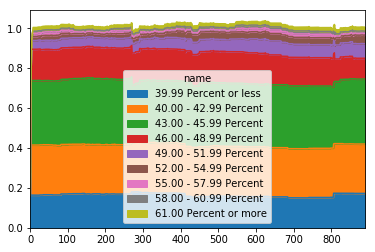

In [444]:
df = t_vote.copy()
for side in ('back', 'lay'):
    df[f'{side}_ewap'] = ewap(df, [f'{side}_price_{i}' for i in range(3)], [f'{side}_size_{i}' for i in range(3)])
df['mid_ewap'] = 1 / ((df.back_ewap + df.lay_ewap) / 2)
df.pivot(columns='name', values='mid_ewap').fillna(method='ffill').plot.area()